<a href="https://colab.research.google.com/github/RAM-1166/Zeotap_assignment/blob/main/Peteti_Ram_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

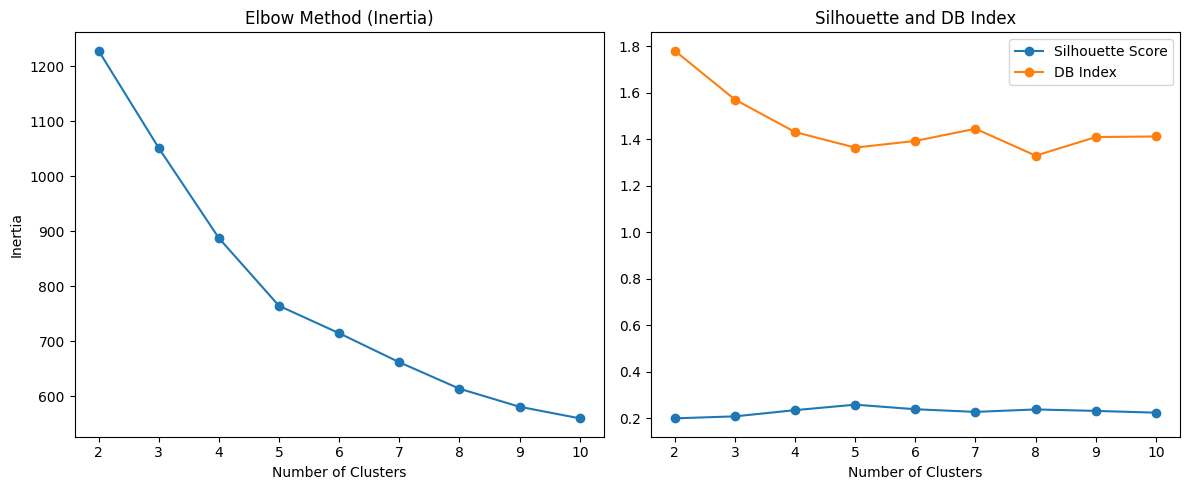

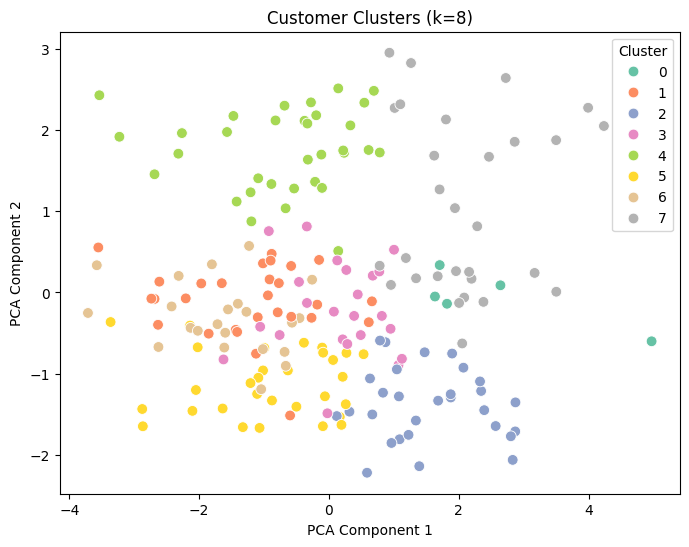

In [2]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
customers = pd.read_csv("/content/drive/MyDrive/Zeotap/Customers.csv")
transactions = pd.read_csv("/content/drive/MyDrive/Zeotap/Transactions.csv")

# Data Preparation
# 1. Aggregate transaction data
transaction_summary = transactions.groupby("CustomerID").agg(
    TotalSpent=("TotalValue", "sum"),
    TotalTransactions=("TransactionID", "count"),
    AvgTransactionValue=("TotalValue", "mean"),
    UniqueCategories=("ProductID", "nunique")
).reset_index()

# 2. Merge with customer data
data = pd.merge(customers, transaction_summary, on="CustomerID", how="inner")

# 3. Feature engineering
data["SignupDays"] = (pd.to_datetime("2025-01-01") - pd.to_datetime(data["SignupDate"])).dt.days

# Encode categorical variables
encoder = OneHotEncoder(drop="first", sparse_output=False)
region_encoded = encoder.fit_transform(data[["Region"]])
region_df = pd.DataFrame(region_encoded, columns=encoder.get_feature_names_out(["Region"]))
data = pd.concat([data, region_df], axis=1)

# Select features for clustering
features = ["TotalSpent", "TotalTransactions", "AvgTransactionValue", "UniqueCategories", "SignupDays"] + list(region_df.columns)
X = data[features]

# Normalize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Determine optimal number of clusters
inertia = []
silhouette_scores = []
db_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))
    db_scores.append(davies_bouldin_score(X_scaled, kmeans.labels_))

# Plot Elbow Method and Silhouette Score
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(2, 11), inertia, marker='o')
plt.title("Elbow Method (Inertia)")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")

plt.subplot(1, 2, 2)
plt.plot(range(2, 11), silhouette_scores, marker='o', label="Silhouette Score")
plt.plot(range(2, 11), db_scores, marker='o', label="DB Index")
plt.title("Silhouette and DB Index")
plt.xlabel("Number of Clusters")
plt.legend()
plt.tight_layout()
plt.show()

# Final clustering
optimal_clusters = np.argmin(db_scores) + 2  # Adjust for index offset
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Add cluster labels to data
data["Cluster"] = clusters

# Visualize clusters (PCA for dimensionality reduction)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)
data["PCA1"] = pca_result[:, 0]
data["PCA2"] = pca_result[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(x="PCA1", y="PCA2", hue="Cluster", data=data, palette="Set2", s=60)
plt.title(f"Customer Clusters (k={optimal_clusters})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()

# Calculate final DB Index
final_db_index = davies_bouldin_score(X_scaled, clusters)
print(f"Davies-Bouldin Index for k={optimal_clusters}: {final_db_index}")
